# Allstate reverse search experiment

In [1]:
import polars as pl
import polars.selectors as cs
from sklearn import cluster
import numpy as np
import numpy.typing as npt
import seaborn as sns
from collections import defaultdict
from statistics import median
import json

In [59]:
sample_modulo = 10
df = pl.read_csv("data/train.csv", null_values="?")
train, validation = df.with_columns((pl.col("id") % sample_modulo == 0).alias("split")).partition_by("split", include_key=False)

In [3]:
print(len(train), len(train.filter(pl.col("loss") != 0)), len(train.filter(pl.col("loss") == 0)))

169497 169497 0


In [3]:
response = train.filter(pl.col("loss") != 0)["loss"]
response.abs().describe()

statistic,value
str,f64
"""count""",169497.0
"""null_count""",0.0
"""mean""",3038.41521
"""std""",2906.773527
"""min""",5.25
"""25%""",1205.1
"""50%""",2116.64
"""75%""",3868.02
"""max""",121012.25


In [35]:
sample = np.log(train["loss"].to_numpy())
clustering = cluster.KMeans(n_clusters=50).fit(sample.reshape(-1, 1))

50 5943
0:3624, 1:4813, 2:5866, 3:3416, 4:4998, 5:4064, 6:5896, 7:247, 8:1382, 9:1172, 10:4181, 11:5609, 12:5892, 13:454, 14:5221, 15:11, 16:4323, 17:3981, 18:4572, 19:2148, 20:4214, 21:864, 22:1772, 23:5178, 24:5861, 25:95, 26:5182, 27:5741, 28:185, 29:767, 30:2256, 31:4149, 32:3888, 33:5626, 34:2907, 35:48, 36:5867, 37:5943, 38:33, 39:3888, 40:496, 41:4264, 42:4618, 43:3886, 44:1058, 45:4951, 46:1462, 47:5396, 48:2810, 49:4222, 
Num of outliers: 3624 0.02138090939662649


<Axes: ylabel='Count'>

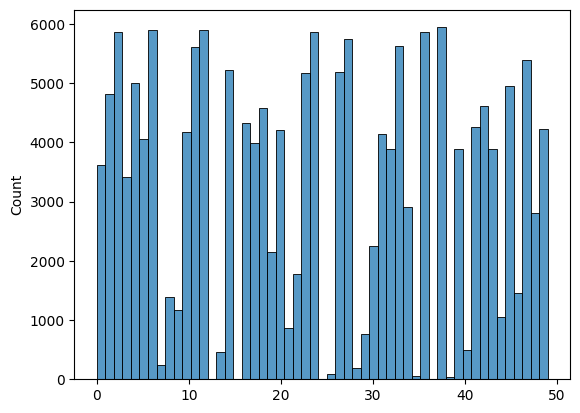

In [36]:
unique, counts = np.unique(clustering.labels_, return_counts=True)
print(len(unique), np.max(counts))
for cluster_id, count in zip(unique, counts):
    print(f"{cluster_id}:{count}", end=", ")
print()
print(f"Num of outliers: {counts[0]} {counts[0]/len(sample)}")
sns.histplot(clustering.labels_)


In [37]:
outliers = [value for value, label in zip(sample, clustering.labels_) if label == -1]
outliers = pl.Series(outliers)
outliers.describe()

statistic,value
str,f64
"""count""",0.0
"""null_count""",0.0


In [44]:
cluster_aggs = defaultdict(lambda : [0.0, 0])
for value, label in zip(np.exp(sample), clustering.labels_):
    aggs = cluster_aggs[label]
    aggs[0] += value
    aggs[1] += 1

label_means = {label: aggs[0]/aggs[1] for label, aggs in cluster_aggs.items()}
if -1 in label_means:
    del label_means[-1]
print(label_means)

cluster_partitioned = defaultdict(lambda: [])
for value, label in zip(np.exp(sample), clustering.labels_):
    cluster_partitioned[label].append(value)
label_medians = {label: median(partition) for label, partition in cluster_partitioned.items()}

if -1 in label_medians:
    del label_medians[-1]
#label_medians[0] = 0.
print({key: label_medians[key] for key in sorted(label_medians.keys())})

#medroid_keys = {cluster_id for cluster_id in clustering.labels_}
#medroid_keys.remove(-1)
#label_medoids = {cluster_id + 1: medoid[0] for cluster_id, medoid in zip(sorted(medroid_keys), clustering.medoids_)}
#print(label_medoids)
#label_medoids[0] = 0.
#print(label_medoids)


{6: 2188.3951797829004, 17: 1299.0858452650127, 37: 3010.0179774524663, 12: 2768.390780719611, 4: 5223.500198079242, 43: 1156.7456073082853, 22: 10375.042183972933, 16: 6490.774654175328, 18: 5809.408094925622, 39: 1226.0751466049383, 5: 1087.1219857283452, 34: 607.4198383212934, 31: 1374.8995902627128, 26: 4303.494851408703, 11: 3929.6126528793125, 32: 737.7453137860068, 10: 806.4549892370246, 0: 7293.514795805743, 1: 1552.0334967795566, 23: 4724.6232715334145, 14: 1766.9161386707553, 47: 1891.1251945885826, 36: 2363.131648201804, 8: 11747.100383502164, 33: 3586.6444898684563, 49: 876.2736499289447, 3: 671.9712470725992, 41: 1015.9431355534704, 2: 3280.7859989771573, 42: 1458.9498722390585, 9: 427.5269965870307, 27: 2031.0739017592741, 29: 15821.662985658406, 46: 492.6584062927497, 48: 8220.046387900355, 24: 2555.522004777338, 20: 945.5924323682963, 15: 23.772727272727273, 19: 550.50136405959, 45: 1655.2000302969097, 30: 9243.52995124112, 13: 19574.971189427328, 7: 221.03712550607287,

In [45]:
print(len(label_medians))
print(max(label_medians.keys()))
print(len(label_means))

50
49
50


<Axes: ylabel='Count'>

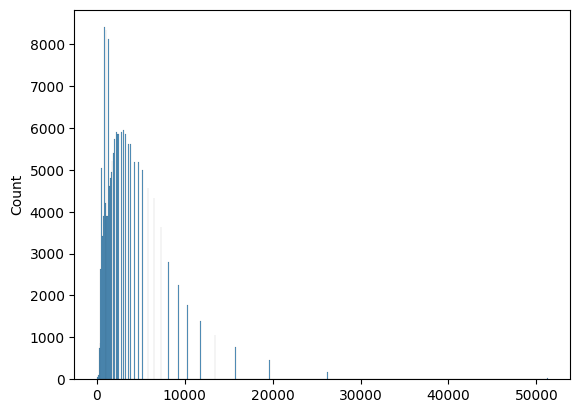

In [46]:
quantised = [label_means[label] for label in clustering.labels_ if label != -1]
sns.histplot(quantised)

In [48]:
train_response = train["loss"]

errors = []
for response in train_response:
    errors.append(min([abs(response - centre) for centre in label_medians.values()]))
print(sum(errors) / len(errors))
        

80.49958261798244


# Build up the sparse representation


In [55]:
sparse = df.clone()

In [57]:
# Do something useful with model age - wrong dataset
# sparse = sparse.with_columns((pl.col("Model_Year") - pl.col("Calendar_Year")).alias("Year_Delta"))

In [58]:
#sparse = sparse.drop("Household_ID", "Calendar_Year", "Model_Year", "Blind_Submodel")

In [56]:
medians = []
for label in sorted(label_medians.keys()):
    medians.append(label_medians[label])
medians_ary = np.array(medians)

def get_cluster(response: npt.NDArray):
    errors = np.absolute((medians_ary - response))
    return errors.argmin()
cluster_ids = sparse["loss"].map_elements(get_cluster, pl.Int32)
sparse = pl.concat([sparse, cluster_ids.to_frame("Cluster_ID")], how="horizontal")

In [51]:
clustered = cluster_ids.replace_strict(label_medians).to_frame("clustered")
compare = pl.concat([clustered, sparse["loss"].to_frame()], how="horizontal")
compare = compare.with_columns((pl.col("clustered") - pl.col("loss")).alias("diff"))

In [57]:
sparse = sparse.to_dummies([cs.string(include_categorical=True)])

In [53]:
for col in sparse.columns:
    print(col, end=', ')

id, cat1_A, cat1_B, cat2_A, cat2_B, cat3_A, cat3_B, cat4_A, cat4_B, cat5_A, cat5_B, cat6_A, cat6_B, cat7_A, cat7_B, cat8_A, cat8_B, cat9_A, cat9_B, cat10_A, cat10_B, cat11_A, cat11_B, cat12_A, cat12_B, cat13_A, cat13_B, cat14_A, cat14_B, cat15_A, cat15_B, cat16_A, cat16_B, cat17_A, cat17_B, cat18_A, cat18_B, cat19_A, cat19_B, cat20_A, cat20_B, cat21_A, cat21_B, cat22_A, cat22_B, cat23_A, cat23_B, cat24_A, cat24_B, cat25_A, cat25_B, cat26_A, cat26_B, cat27_A, cat27_B, cat28_A, cat28_B, cat29_A, cat29_B, cat30_A, cat30_B, cat31_A, cat31_B, cat32_A, cat32_B, cat33_A, cat33_B, cat34_A, cat34_B, cat35_A, cat35_B, cat36_A, cat36_B, cat37_A, cat37_B, cat38_A, cat38_B, cat39_A, cat39_B, cat40_A, cat40_B, cat41_A, cat41_B, cat42_A, cat42_B, cat43_A, cat43_B, cat44_A, cat44_B, cat45_A, cat45_B, cat46_A, cat46_B, cat47_A, cat47_B, cat48_A, cat48_B, cat49_A, cat49_B, cat50_A, cat50_B, cat51_A, cat51_B, cat52_A, cat52_B, cat53_A, cat53_B, cat54_A, cat54_B, cat55_A, cat55_B, cat56_A, cat56_B, cat57_

In [60]:
train, validation = sparse.with_columns((pl.col("id") % sample_modulo == 0).alias("split")).partition_by("split", include_key=False)
train = train.drop("id")
validation = validation.drop("id")

In [61]:
cluster_ids, cluster_vals = zip(* label_medians.items())
clusters_df = pl.DataFrame({"cluster_id": cluster_ids, "cluster_value": cluster_vals})
clusters_df.write_parquet("data/clusters.parquet")
train.write_parquet("data/rs_train.parquet")
validation.write_parquet("data/rs_validation.parquet")

# Validating poly learn

In [144]:
iter0_samples = pl.read_parquet("exp1/samples.parquet")
iter0_features = iter0_samples.drop(["loss", "Cluster_ID"]).to_numpy()
iter0_features = np.concatenate([iter0_features, np.ones([len(iter0_features), 1])], dtype="float64", axis=1)
iter0_response = iter0_samples["loss"].to_numpy()
dim = iter0_features.shape[1]
states_out = pl.read_parquet("exp1/states_out/states.parquet")
clusters_parquet = pl.read_parquet("data/clusters.parquet")
iter0_clusters_dict = dict(zip(clusters_parquet["cluster_id"], clusters_parquet["cluster_value"]))
iter0_clusters = np.array([iter0_clusters_dict[cl_ind] for cl_ind in sorted(iter0_clusters_dict.keys())])
with open("exp1/projection_dump.json") as proj_file:
    projection = np.array(json.load(proj_file))
    projection = np.reshape(projection.transpose(), [-1, dim, projection.shape[0]])

In [145]:
projection[:, :, 99]

array([[-0.82508839,  0.92549659,  0.20769747, ...,  1.43133789,
        -2.04328083, -0.94309212],
       [-0.33692508, -0.10736684, -0.90494529, ...,  1.31673723,
        -0.65562332, -0.49028576],
       [ 0.02485596,  0.66936008,  0.109336  , ...,  1.55024276,
        -1.27658971,  3.57772224],
       ...,
       [-0.43590425, -1.19828938,  0.5546638 , ..., -0.22269218,
        -0.32081998, -1.73759513],
       [-0.43359609,  0.60300083,  0.99080585, ...,  0.6742367 ,
        -0.3080414 , -0.26910392],
       [-1.32038093,  1.40004152,  0.02720965, ..., -1.67123744,
        -0.35114639,  0.60270582]])

In [146]:
initial_rs_param = np.zeros([projection.shape[-1]])
initial_rs_param[-1] = 1
def update_params(rs_param: npt.NDArray[np.float64], features: npt.NDArray[np.float64]):
    updated = projection @ rs_param
    #print(updated.shape)
    scores = features @ updated.transpose()
    #print(scores.shape)
    maximised = scores.argmax(axis=1)
    print(maximised)
    return maximised

In [147]:
def compute_mae(decomp: npt.NDArray[np.int32]):
    return np.abs(response - iter0_clusters[decomp]).mean()
#print(compute_mae(maximised))

In [148]:
states = pl.read_parquet("exp1/states_out/states.parquet").to_numpy()
print(states.dtype)
filtered = [s for s in states if s[-1] > 0]

for state in filtered:
    updated_params = update_params(state, iter0_features)
    print(compute_mae(updated_params))

float64
5423.5759499999995
5418.9346
5416.7880000000005
5416.7880000000005
5427.07565
5422.87885
5427.731650000001
5410.818200000001
5430.81775
5406.778400000001
5397.4552
5473.2144
5608.4608499999995
5598.173200000001
5588.1636
5595.5278
5576.5532
5604.96115
5607.7759
5568.639749999999
5612.202949999999
5595.104200000001
5602.858149999999
5858.245
5841.705849999999
5862.449250000001
5740.87255
5812.10625
5812.76225
5744.58175
5813.5311
5811.429749999999
5751.0668
5812.1137
5789.231
5799.173200000001
5756.192150000001
5813.531100000001
5758.32555
5758.32555
5820.0526
5760.23195
5821.4455499999995
5761.97595
5761.97595
5761.97595
5751.0668
5753.76505
5764.954299999999
5765.69635
5766.20175
5768.348349999999
5769.2762
5770.11885
5770.7056
5770.87265
5770.87265
5770.87265
5795.42535
5771.60865
5817.2413
5772.0669
5082.0844
5066.02115
5063.87455
5059.233200000001
5059.233200000001
5069.52085
5069.9654
5057.0866000000005
5070.176850000001
5067.374250000001
5067.374250000001
5063.17745
5077.

In [141]:
big_np = train.to_numpy()
updated_params = update_params(state, iter0_features)
print(compute_mae(updated_params))

3631.5657000000006
